In [362]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV

In [64]:
# load WHO TB Burden - incidence number 2023 + severity level, enriched with external data + corrections done in EDA
TB_burden_enriched = "df_TB_burden_enriched_new.csv"
df_TB_burden_enriched = pd.read_csv(TB_burden_enriched)
df_TB_burden_enriched

,country_name,iso2,iso3,iso_numeric,g_whoregion,year,e_pop_num,e_inc_num,e_tbhiv_prct,e_inc_tbhiv_num,...,targets_number,doses,BCG_coverage,population_density,MPI_value,pop_in_MP_percent,total_smokers_2022_percent,avg_air_pollution_PM2-5_in_2023,e_tb_inc_prct,tb_severity
0,Afghanistan,AF,AFG,4,EMR,2023,41454760,75000,0.03,19.0,...,2057002.0,1969540.0,95.75,63.8457,0.271721,55.910239,22.7,NaN,0.180920,Moderate
1,Albania,AL,ALB,8,EUR,2023,2811661,430,1.10,4.0,...,22887.0,22703.0,99.20,102.6226,0.002748,0.703561,21.9,16.7,0.015293,Very Low
2,Algeria,DZ,DZA,12,AFR,2023,46164214,22000,0.83,180.0,...,936973.0,924725.0,98.69,19.3826,0.005409,1.380835,21.2,13.8,0.047656,Very Low
3,American Samoa,AS,ASM,16,WPR,2023,47521,2,0.37,0.0,...,NaN,NaN,NaN,237.6050,NaN,NaN,NaN,NaN,0.004209,Very Low
4,Andorra,AD,AND,20,EUR,2023,80854,5,0.47,0.0,...,NaN,NaN,NaN,172.0340,NaN,NaN,36.3,7.9,0.006184,Very Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Viet Nam,VN,VNM,704,WPR,2023,100352197,182000,2.50,4600.0,...,1267834.0,1205427.0,95.08,320.1956,0.007729,1.919121,22.5,29.6,0.181361,Moderate
210,Wallis and Futuna,WF,WLF,876,WPR,2023,11377,0,0.15,0.0,...,NaN,NaN,NaN,81.2179,NaN,NaN,NaN,NaN,0.000000,Very Low
211,Yemen,YE,YEM,887,EMR,2023,39390797,19000,0.72,140.0,...,1254398.0,802445.0,63.97,74.6080,0.245166,48.466429,21.4,NaN,0.048235,Very Low
212,Zambia,ZM,ZMB,894,AFR,2023,20723959,59000,32.00,19000.0,...,877840.0,707320.0,80.58,27.8776,0.231685,47.906131,14.6,24.1,0.284695,High


In [66]:
# Summary of the data: checking data types
column_summary_df_TB_burden_enriched = pd.DataFrame({
    'Column Name': df_TB_burden_enriched.columns,
    'Data Type': df_TB_burden_enriched.dtypes.values,
    'Non-Null Count': df_TB_burden_enriched.notnull().sum().values,
    'Null Count': df_TB_burden_enriched.isnull().sum().values,
    'Data Type': df_TB_burden_enriched.dtypes.values,
    'Percentage Null': df_TB_burden_enriched.isnull().mean().values * 100,
    'Unique Values': df_TB_burden_enriched.nunique().values
})

print(column_summary_df_TB_burden_enriched)

                        Column Name Data Type  Non-Null Count  Null Count  \
0                      country_name    object             214           0   
1                              iso2    object             213           1   
2                              iso3    object             214           0   
3                       iso_numeric     int64             214           0   
4                       g_whoregion    object             214           0   
5                              year     int64             214           0   
6                         e_pop_num     int64             214           0   
7                         e_inc_num     int64             214           0   
8                      e_tbhiv_prct   float64             214           0   
9                   e_inc_tbhiv_num   float64             214           0   
10             e_mort_exc_tbhiv_num   float64             213           1   
11                 e_mort_tbhiv_num   float64             211           3   

In [68]:
# change all integer features into floats: e_pop_num, e_inc_num, e_inc_rr_num
columns_to_convert = ["e_pop_num", "e_inc_num", "e_inc_rr_num"]
df_TB_burden_enriched[columns_to_convert] = df_TB_burden_enriched[columns_to_convert].astype(float)
df_TB_burden_enriched.dtypes.values

array([dtype('O'), dtype('O'), dtype('O'), dtype('int64'), dtype('O'),
       dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'),
       dtype('float64'), dtype('O'), dtype('O'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('O')], dtype=object)

In [70]:
# assign grade numerical values to TB_severity and store in a new TB_severity_level column:
TB_severity_mapping = {"Very Low": 1, "Low": 2, "Moderate": 3, "High": 4, "Critical": 5}
df_TB_burden_enriched["tb_severity_level"] = df_TB_burden_enriched["tb_severity"].map(TB_severity_mapping)
df_TB_burden_enriched.head(50)

,country_name,iso2,iso3,iso_numeric,g_whoregion,year,e_pop_num,e_inc_num,e_tbhiv_prct,e_inc_tbhiv_num,...,doses,BCG_coverage,population_density,MPI_value,pop_in_MP_percent,total_smokers_2022_percent,avg_air_pollution_PM2-5_in_2023,e_tb_inc_prct,tb_severity,tb_severity_level
0,Afghanistan,AF,AFG,4,EMR,2023,4.145476e+07,75000.0,0.03,19.0,...,1969540.0,95.75,63.8457,0.271721,55.910239,22.7,NaN,0.180920,Moderate,3
1,Albania,AL,ALB,8,EUR,2023,2.811661e+06,430.0,1.10,4.0,...,22703.0,99.20,102.6226,0.002748,0.703561,21.9,16.7,0.015293,Very Low,1
2,Algeria,DZ,DZA,12,AFR,2023,4.616421e+07,22000.0,0.83,180.0,...,924725.0,98.69,19.3826,0.005409,1.380835,21.2,13.8,0.047656,Very Low,1
3,American Samoa,AS,ASM,16,WPR,2023,4.752100e+04,2.0,0.37,0.0,...,NaN,NaN,237.6050,NaN,NaN,NaN,NaN,0.004209,Very Low,1
4,Andorra,AD,AND,20,EUR,2023,8.085400e+04,5.0,0.47,0.0,...,NaN,NaN,172.0340,NaN,NaN,36.3,7.9,0.006184,Very Low,1
5,Angola,AO,AGO,24,AFR,2023,3.674991e+07,125000.0,7.90,9800.0,...,1163980.0,95.52,29.4777,0.282435,51.104112,NaN,7.8,0.340137,High,4
6,Anguilla,AI,AIA,660,AMR,2023,1.441300e+04,3.0,8.20,0.0,...,167.0,109.87,163.7500,NaN,NaN,NaN,7.4,0.020815,Very Low,1
7,Antigua and Barbuda,AG,ATG,28,AMR,2023,9.331700e+04,1.0,1.20,0.0,...,NaN,NaN,212.0807,NaN,NaN,NaN,NaN,0.001072,Very Low,1
8,Argentina,AR,ARG,32,AMR,2023,4.553841e+07,16000.0,6.10,980.0,...,339846.0,68.77,16.3114,0.001469,0.432323,23.8,9.2,0.035135,Very Low,1
9,Armenia,AM,ARM,51,EUR,2023,2.943390e+06,720.0,11.00,83.0,...,32287.0,98.54,103.4076,0.000690,0.190553,24.9,26.4,0.024462,Very Low,1


In [72]:
# Check if the dataframe is of the correct type
print(type(df_TB_burden_enriched))  # Should return <class 'pandas.DataFrame'>

<class 'pandas.core.frame.DataFrame'>


In [90]:
# Select features and target columns: 10 features + 2 targets
df_TB_burden_selected = df_TB_burden_enriched[["e_tbhiv_prct", "cfr_pct", "c_cdr", "e_rr_pct_new", "BCG_coverage", "population_density","MPI_value",
                                               "pop_in_MP_percent", "total_smokers_2022_percent", "avg_air_pollution_PM2-5_in_2023", "e_tb_inc_prct", "tb_severity_level"]]
df_TB_burden_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   e_tbhiv_prct                     214 non-null    float64
 1   cfr_pct                          196 non-null    float64
 2   c_cdr                            192 non-null    float64
 3   e_rr_pct_new                     214 non-null    float64
 4   BCG_coverage                     156 non-null    float64
 5   population_density               214 non-null    float64
 6   MPI_value                        109 non-null    float64
 7   pop_in_MP_percent                109 non-null    float64
 8   total_smokers_2022_percent       164 non-null    float64
 9   avg_air_pollution_PM2-5_in_2023  131 non-null    float64
 10  e_tb_inc_prct                    214 non-null    float64
 11  tb_severity_level                214 non-null    int64  
dtypes: float64(11), int64(

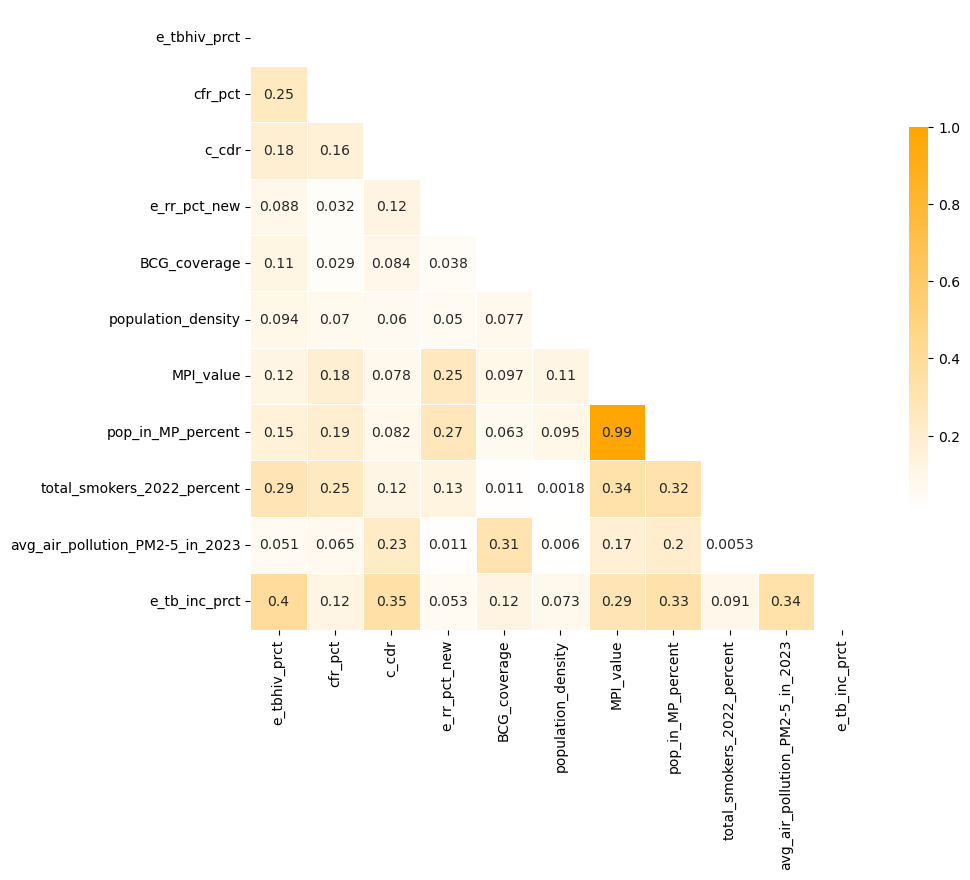

In [94]:
# Selection of features based on correlactions between themselves but also with the targets.
# Desired is a low correlaction between features, but a high correlaction between features and targets.
# Generate a heatmap for visualization of correlation:

df_TB_burden_selected_noSevLev = df_TB_burden_selected.drop(columns=["tb_severity_level"])
corr=np.abs(df_TB_burden_selected_noSevLev.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Define a custom colormap from white to orange
colors = ["white", "orange"]
cmap = LinearSegmentedColormap.from_list("white_orange", colors)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot = True)

plt.show()

In [82]:
# Select feature columns: 9 features selected, 1 dropped
df_TB_burden_selected = df_TB_burden_selected.drop(["pop_in_MP_percent"], axis=1)
df_TB_burden_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   e_tbhiv_prct                     214 non-null    float64
 1   cfr_pct                          196 non-null    float64
 2   c_cdr                            192 non-null    float64
 3   e_rr_pct_new                     214 non-null    float64
 4   BCG_coverage                     156 non-null    float64
 5   population_density               214 non-null    float64
 6   MPI_value                        109 non-null    float64
 7   total_smokers_2022_percent       164 non-null    float64
 8   avg_air_pollution_PM2-5_in_2023  131 non-null    float64
 9   e_tb_inc_prct                    214 non-null    float64
 10  tb_severity                      214 non-null    object 
dtypes: float64(10), object(1)
memory usage: 18.5+ KB


In [84]:
# Feature and Target selection
# Define feature columns and put them into a new dataframe
df_TB_burden_feature = df_TB_burden_selected.drop(["e_tb_inc_prct", "tb_severity"], axis=1)
df_TB_burden_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   e_tbhiv_prct                     214 non-null    float64
 1   cfr_pct                          196 non-null    float64
 2   c_cdr                            192 non-null    float64
 3   e_rr_pct_new                     214 non-null    float64
 4   BCG_coverage                     156 non-null    float64
 5   population_density               214 non-null    float64
 6   MPI_value                        109 non-null    float64
 7   total_smokers_2022_percent       164 non-null    float64
 8   avg_air_pollution_PM2-5_in_2023  131 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [100]:
# Define "TB_severity_level" as target for a categorical prediction model
df_TB_burden_target = df_TB_burden_selected["tb_severity_level"]
df_TB_burden_target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 214 entries, 0 to 213
Series name: tb_severity_level
Non-Null Count  Dtype
--------------  -----
214 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


In [102]:
# Train Test Split of the dataset
# split X (features) and y (target) into X_train, X_test, y_train, and y_test. 
# 80% of the data should be in the training set and 20% in the test set.

X_train, X_test, y_train, y_test = train_test_split(df_TB_burden_feature, df_TB_burden_target, test_size=0.20, random_state=0)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 16 to 172
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   e_tbhiv_prct                     171 non-null    float64
 1   cfr_pct                          158 non-null    float64
 2   c_cdr                            154 non-null    float64
 3   e_rr_pct_new                     171 non-null    float64
 4   BCG_coverage                     126 non-null    float64
 5   population_density               171 non-null    float64
 6   MPI_value                        91 non-null     float64
 7   total_smokers_2022_percent       135 non-null    float64
 8   avg_air_pollution_PM2-5_in_2023  109 non-null    float64
dtypes: float64(9)
memory usage: 13.4 KB


In [104]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 197 to 139
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   e_tbhiv_prct                     43 non-null     float64
 1   cfr_pct                          38 non-null     float64
 2   c_cdr                            38 non-null     float64
 3   e_rr_pct_new                     43 non-null     float64
 4   BCG_coverage                     30 non-null     float64
 5   population_density               43 non-null     float64
 6   MPI_value                        18 non-null     float64
 7   total_smokers_2022_percent       29 non-null     float64
 8   avg_air_pollution_PM2-5_in_2023  22 non-null     float64
dtypes: float64(9)
memory usage: 3.4 KB


In [106]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 171 entries, 16 to 172
Series name: tb_severity_level
Non-Null Count  Dtype
--------------  -----
171 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB


In [108]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 43 entries, 197 to 139
Series name: tb_severity_level
Non-Null Count  Dtype
--------------  -----
43 non-null     int64
dtypes: int64(1)
memory usage: 688.0 bytes


In [110]:
# Normlization: MinMax Scaler for standardization: few outliers & no normal distribution
normalizer = MinMaxScaler()

In [112]:
# fitting = calculating min and max for each column
normalizer.fit(X_train)

MinMaxScaler()

In [114]:
# transforming = using the min and max data to scale the rest of the values
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [116]:
# The normalizer returns an array instead of a dataframe
X_train_norm

array([[0.00322581, 0.11111111, 0.36046512, ..., 0.20060307, 0.65777778,
        1.        ],
       [0.00548387, 0.03030303, 0.40116279, ...,        nan, 0.19777778,
        0.0104712 ],
       [0.00774194, 0.1010101 , 0.36046512, ...,        nan,        nan,
               nan],
       ...,
       [0.09032258, 0.02020202, 0.40116279, ...,        nan, 0.47555556,
        0.11125654],
       [0.        , 0.07070707, 0.40116279, ...,        nan, 0.52666667,
               nan],
       [0.02096774, 0.        , 0.40116279, ...,        nan, 0.29111111,
        0.12958115]])

In [118]:
# creating a dataframe of the X_train array again
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,e_tbhiv_prct,cfr_pct,c_cdr,e_rr_pct_new,BCG_coverage,population_density,MPI_value,total_smokers_2022_percent,avg_air_pollution_PM2-5_in_2023
0,0.003226,0.111111,0.360465,0.023661,0.776562,0.050377,0.200603,0.657778,1.000000
1,0.005484,0.030303,0.401163,0.045417,0.000000,0.000742,NaN,0.197778,0.010471
2,0.007742,0.101010,0.360465,0.016318,0.436691,0.006149,NaN,NaN,NaN
3,0.000000,0.070707,0.401163,0.050857,NaN,0.045820,NaN,NaN,0.007853
4,0.000000,0.070707,0.401163,0.064455,NaN,0.011767,NaN,NaN,NaN


In [120]:
# same for the X_test array
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

,e_tbhiv_prct,cfr_pct,c_cdr,e_rr_pct_new,BCG_coverage,population_density,MPI_value,total_smokers_2022_percent,avg_air_pollution_PM2-5_in_2023
0,0.225806,0.090909,0.401163,0.067174,0.595926,0.001855,NaN,NaN,NaN
1,0.000000,0.070707,0.401163,0.029100,0.562345,0.011586,NaN,NaN,NaN
2,0.024194,0.111111,0.389535,0.061735,0.523810,0.018495,0.132366,0.466667,0.66623
3,0.096774,NaN,NaN,0.034539,0.479494,0.001057,NaN,0.746667,NaN
4,0.161290,0.010101,0.401163,0.023661,0.592141,0.010703,0.004898,0.375556,NaN


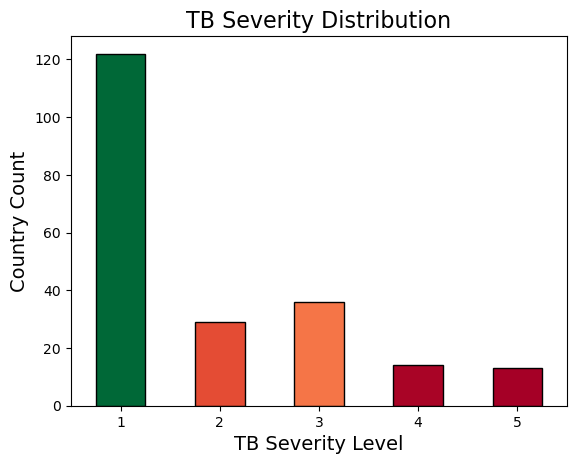

In [148]:
# Check for balance of the target variable: TB_severity_level
severity = df_TB_burden_selected["tb_severity_level"].value_counts().sort_index()

# Normalize values to range between 0 and 1
norm = mcolors.Normalize(vmin=severity.min(), vmax=severity.max())
colors = [cm.RdYlGn(norm(val)) for val in severity]

# Plot with custom colors
severity.plot(kind="bar", color=colors, edgecolor="black")
plt.xlabel("TB Severity Level", fontsize=14)
plt.xticks(rotation=0)
plt.ylabel("Country Count", fontsize=14)
plt.title("TB Severity Distribution", fontsize=16)
plt.show()

In [168]:
# Running Ensemble ML Modelling Methods: HistGradientBoostingClassifier
# Initialize (create) and train HistGradientBoostingClassifier model
HGBC = HistGradientBoostingClassifier(max_iter=100, random_state=0)  # using the default hyperparameters
HGBC.fit(X_train_norm, y_train)

HistGradientBoostingClassifier(random_state=0)

In [170]:
# Evaluate model's performance: Predicting the fit for the test data
pred_HGBC = HGBC.predict(X_test_norm)
pred_HGBC

array([1, 1, 1, 1, 1, 1, 1, 2, 4, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1],
      dtype=int64)

In [172]:
# Check for the real TB severity level values of the dataset
y_test.values

array([1, 1, 3, 2, 1, 1, 1, 2, 4, 4, 5, 4, 2, 3, 2, 1, 1, 1, 1, 2, 3, 2,
       1, 5, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2],
      dtype=int64)

In [174]:
# Calculate the accuracy of the HistGradientBoostingClassifier model 
accuracy_HGBC = HGBC.score(X_test_norm, y_test)
accuracy_HGBC

0.5581395348837209

In [180]:
# Evaluate HistGradientBoostingClassifier model's performance also checking for precision, recall, F1-score
print(classification_report(y_pred = pred_HGBC, y_true = y_test))

              precision    recall  f1-score   support

           1       0.66      0.81      0.72        26
           2       0.50      0.29      0.36         7
           3       0.00      0.00      0.00         3
           4       1.00      0.20      0.33         5
           5       0.00      0.00      0.00         2

    accuracy                           0.56        43
   macro avg       0.43      0.26      0.28        43
weighted avg       0.59      0.56      0.54        43



In [360]:
# Check what are the most relevant features for the HistGradientBoostingClassifier model:
# Extract feature importances
HGBC_importances = HGBC.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(HGBC_importances)[::-1]

# Print the most important features
for idx in sorted_indices:
    print(f"Feature {idx}: Importance {HGBC_importances[idx]:.4f}")

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

In [384]:
# Check what are the most relevant features for the HistGradientBoostingClassifier model:
# Compute permutation importance
HGBC_importances = permutation_importance(HGBC, X_test_norm, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Compute total absolute permutation importance
total_HGBC_importance = np.sum(np.abs(HGBC_importances.importances), axis=1)  # Sum across all repetitions

# Sort features by importance
sorted_indices = np.argsort(total_HGBC_importance)[::-1]

# Print absolute permutation feature importances
print("Feature Importances (Total Permutation Importance Method):")
for idx in sorted_indices:
    print(f"Feature {X_test_norm.columns[idx]}: Total Importance {total_HGBC_importance[idx]:.4f}")

Feature Importances (Total Permutation Importance Method):
Feature cfr_pct: Total Importance 0.4419
Feature MPI_value: Total Importance 0.3953
Feature c_cdr: Total Importance 0.3953
Feature e_tbhiv_prct: Total Importance 0.2791
Feature BCG_coverage: Total Importance 0.2791
Feature avg_air_pollution_PM2-5_in_2023: Total Importance 0.2558
Feature population_density: Total Importance 0.2558
Feature e_rr_pct_new: Total Importance 0.2558
Feature total_smokers_2022_percent: Total Importance 0.2326


C:\Users\admin\AppData\Local\Temp\ipykernel_103804\1880466254.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_HGBC_importance, x="Total Importance", y="Feature", palette="viridis")


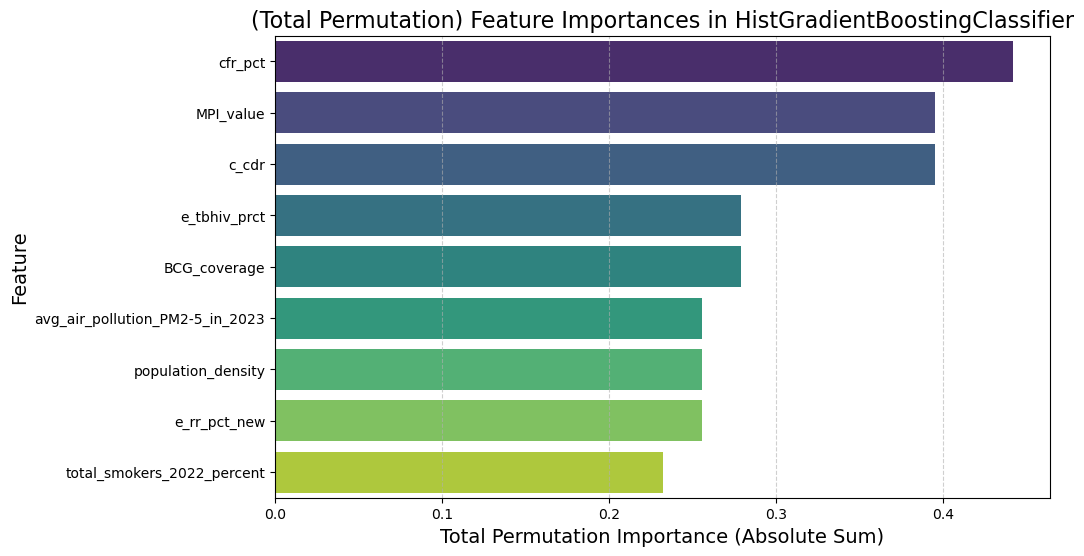

In [386]:
# Create DataFrame for visualization
df_HGBC_importance = pd.DataFrame({
    "Feature": X_test_norm.columns[sorted_indices],
    "Total Importance": total_HGBC_importance[sorted_indices]
})

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=df_HGBC_importance, x="Total Importance", y="Feature", palette="viridis")

# Formatting
plt.xlabel("Total Permutation Importance (Absolute Sum)", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("(Total Permutation) Feature Importances in HistGradientBoostingClassifier", fontsize=16)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Show plot
plt.show()

In [182]:
# Running Ensemble ML Modelling Methods: RandomForestClassifier
# Initialize (create) and train RandomForestClassifier model
RFC = RandomForestClassifier(n_estimators=100, class_weight=None, random_state=0,)  # using the default hyperparameters
RFC.fit(X_train_norm, y_train)

RandomForestClassifier(random_state=0)

In [184]:
# Evaluate model's performance: Predicting the fit for the test data
pred_RFC = RFC.predict(X_test_norm)
pred_RFC

array([1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 4, 3, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [186]:
# Calculate the accuracy of the RandomForestClassifier model 
accuracy_RFC = RFC.score(X_test_norm, y_test)
accuracy_RFC

0.627906976744186

In [188]:
# Evaluate RandomForestClassifier model's performance also checking for precision, recall, F1-score
print(classification_report(y_pred = pred_RFC, y_true = y_test))

              precision    recall  f1-score   support

           1       0.75      0.92      0.83        26
           2       0.00      0.00      0.00         7
           3       0.33      1.00      0.50         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2

    accuracy                           0.63        43
   macro avg       0.22      0.38      0.27        43
weighted avg       0.48      0.63      0.54        43



C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [192]:
# Check what are the most relevant features for the RandomForestClassifier model:
RFC_importance = {feature : importance for feature, importance in zip(X_train_norm.columns, RFC.feature_importances_)}
RFC_importance

{'e_tbhiv_prct': 0.07873460886628823,
 'cfr_pct': 0.08590142778517469,
 'c_cdr': 0.12920513034812178,
 'e_rr_pct_new': 0.08265274020496037,
 'BCG_coverage': 0.145317058715612,
 'population_density': 0.09147486860144975,
 'MPI_value': 0.19192673707097105,
 'total_smokers_2022_percent': 0.11373321045678403,
 'avg_air_pollution_PM2-5_in_2023': 0.08105421795063811}

In [200]:
# Extract feature importances
feature_importances = RFC.feature_importances_

# Define feature_names
feature_names = X_train_norm.columns

# Create a DataFrame for better visualization
RFC_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by Importance in descending order
df_RFC_importance = RFC_importance.sort_values(by='Importance', ascending=False)

# Print sorted feature importances
print("Feature Importances:\n", df_RFC_importance)

Feature Importances:
                            Feature  Importance
6                        MPI_value    0.191927
4                     BCG_coverage    0.145317
2                            c_cdr    0.129205
7       total_smokers_2022_percent    0.113733
5               population_density    0.091475
1                          cfr_pct    0.085901
3                     e_rr_pct_new    0.082653
8  avg_air_pollution_PM2-5_in_2023    0.081054
0                     e_tbhiv_prct    0.078735


C:\Users\admin\AppData\Local\Temp\ipykernel_103804\827634691.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_RFC_importance['Importance'], y=df_RFC_importance['Feature'], palette='viridis')


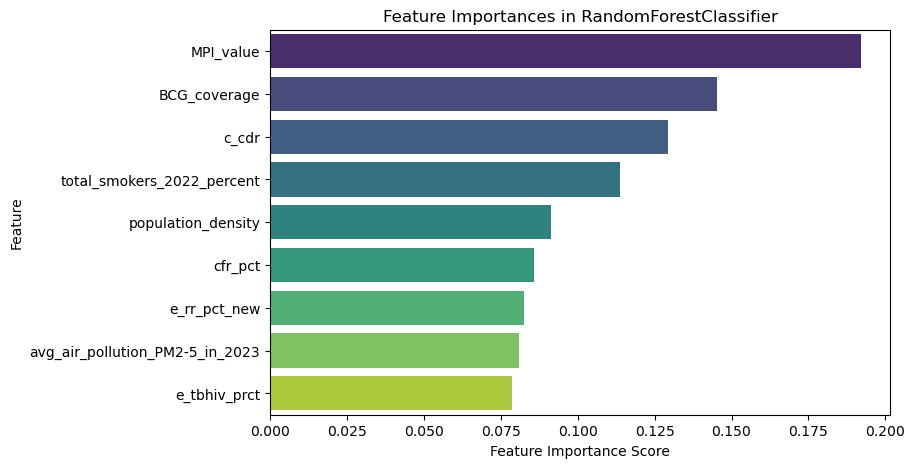

In [206]:
# Visualization of the Feature Importance in the Random Forest Classifier Model:
plt.figure(figsize=(8, 5))
sns.barplot(x=df_RFC_importance['Importance'], y=df_RFC_importance['Feature'], palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances in RandomForestClassifier')
plt.show()

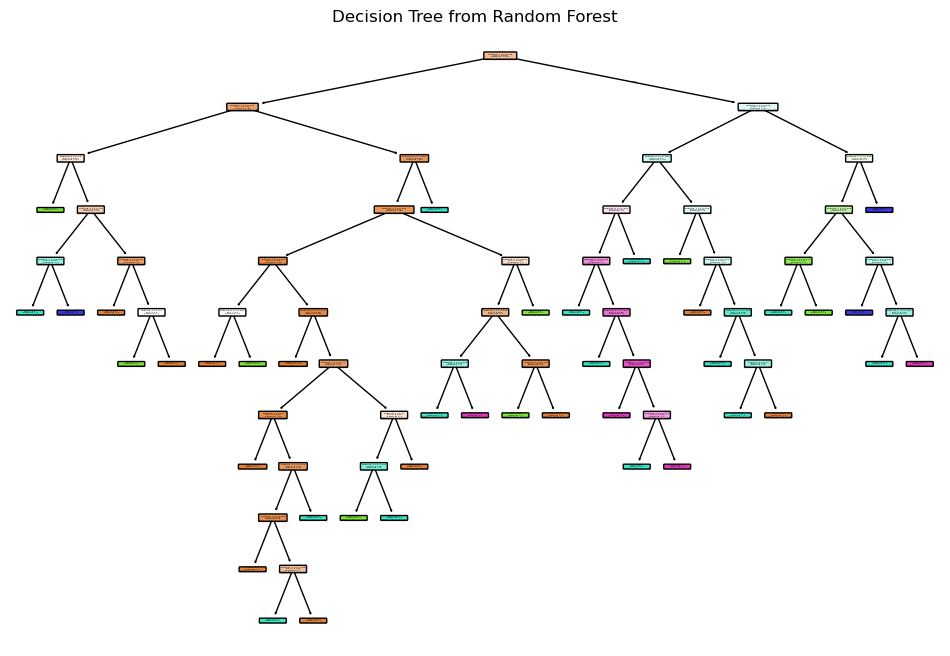

In [226]:
# Select a single tree from the Random Forest (e.g. first tree)
tree = RFC.estimators_[0]

# Visualization of the Decision Tree nodes of the first tree in the Random Forest:
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=[f'Feature_{i+1}' for i in range(X_train_norm.shape[1])], filled=True, rounded=True)
plt.title("Decision Tree from Random Forest")
# Safe the plot (needs to be done first, before showing it!)
#plt.savefig("TB_burden_RandomForest.png", dpi=500)
####  ONLY RUN ONCE !!!! ####
plt.show()

In [238]:
# Impute the missing values (NaN) using an KNN model

imputer = KNNImputer(n_neighbors=5)  # Use k-nearest neighbors to fill missing values
X_imputed = imputer.fit_transform(X_train_norm) # Apply imputation

In [290]:
# Balancing of data according to TB severity level (target)

# Option 1: Resample the minority class using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_imputed, y_train)
# Ensure feature names are retained
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_norm.columns)

# Option 2: Adjusting class weights (TB severity level balancing)
classes=[1, 2, 3, 4, 5]
class_weights = compute_class_weight(class_weight='balanced', y=y_train, classes = np.array(classes))
class_weight_dict = dict(zip([1, 2, 3, 4, 5], class_weights))

In [292]:
# Initialize the Random Forest Classifier model with class weights
RFC_CW = RandomForestClassifier(class_weight=class_weight_dict, random_state=0)

# Train the Random Forest Classifier class weighted model on the original data
RFC_CW.fit(X_train_norm, y_train) 

RandomForestClassifier(class_weight={1: 0.35625, 2: 1.5545454545454545,
                                     3: 1.0363636363636364, 4: 3.8,
                                     5: 3.109090909090909},
                       random_state=0)

In [294]:
# Initialize the Random Forest Classifier model without class weights
RFC_SMOTE = RandomForestClassifier(n_estimators=100, class_weight=None, random_state=0,)  # using the default hyperparameters

# Train the Random Forest Classifier class on the resampled data
RFC_SMOTE.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=0)

In [296]:
# Initialize the Random Forest Classifier model with class weights
RFC_CW_SMOTE = RandomForestClassifier(class_weight=class_weight_dict, random_state=0)

# Train the Random Forest Classifier class weighted model on the resampled data
RFC_CW_SMOTE.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight={1: 0.35625, 2: 1.5545454545454545,
                                     3: 1.0363636363636364, 4: 3.8,
                                     5: 3.109090909090909},
                       random_state=0)

In [298]:
# Evaluate model's performance: Predicting the fit for the test data
pred_RFC_CW = RFC_CW.predict(X_test_norm)
pred_RFC_CW

array([1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 4, 3, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [300]:
# Evaluate model's performance: Predicting the fit for the test data
pred_RFC_SMOTE = RFC_SMOTE.predict(X_test_norm)
pred_RFC_SMOTE

array([1, 1, 1, 5, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 3, 5, 1, 3, 1, 3, 5, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 4],
      dtype=int64)

In [302]:
# Evaluate model's performance: Predicting the fit for the test data
pred_RFC_CW_SMOTE = RFC_CW_SMOTE.predict(X_test_norm)
pred_RFC_CW_SMOTE

array([4, 1, 1, 5, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 1,
       1, 1, 2, 3, 5, 1, 3, 1, 5, 5, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1],
      dtype=int64)

In [304]:
# Evaluate RandomForestClassifier + Class Weights model's performance:
print(classification_report(y_pred = pred_RFC_CW, y_true = y_test))

              precision    recall  f1-score   support

           1       0.71      0.96      0.82        26
           2       0.00      0.00      0.00         7
           3       0.50      1.00      0.67         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2

    accuracy                           0.65        43
   macro avg       0.24      0.39      0.30        43
weighted avg       0.47      0.65      0.54        43



C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [306]:
# Evaluate RandomForestClassifier + Class Weights model's performance:
print(classification_report(y_pred = pred_RFC_SMOTE, y_true = y_test))

              precision    recall  f1-score   support

           1       0.67      0.69      0.68        26
           2       1.00      0.14      0.25         7
           3       0.18      0.67      0.29         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2

    accuracy                           0.49        43
   macro avg       0.37      0.30      0.24        43
weighted avg       0.58      0.49      0.47        43



In [308]:
# Evaluate RandomForestClassifier + Class Weights model's performance:
print(classification_report(y_pred = pred_RFC_CW_SMOTE, y_true = y_test))

              precision    recall  f1-score   support

           1       0.60      0.58      0.59        26
           2       0.00      0.00      0.00         7
           3       0.18      0.67      0.29         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2

    accuracy                           0.40        43
   macro avg       0.16      0.25      0.17        43
weighted avg       0.38      0.40      0.38        43



In [324]:
# Hyperparameter tuning for HisGradientBoosting Classifier:
# It can be fine-tuned using various hyperparameters, such as learning_rate, max_iter, and max_depth
# Cross Validation using Grid Search --> all combinations of tuned hyperparameters will be tested
# learning_rate=0.1 is default, controls the step size at each boosting iteration. Lower values make learning slower but more accurate. Higher values speed up training but may overfit.
# max_iter=100 is default, the number of boosting iterations (trees). Too many iterations can cause overfitting.
# max_depth=None is default, controls how deep each tree can grow. Deeper trees capture more complexity but risk overfitting.
# min_samples_leaf=20 is default, minimum number of samples required to split a node. Larger values help prevent overfitting.

grid = {"learning_rate":[0.01, 0.05, 0.1, 0.2], 
        "max_iter":[100, 200, 500, 1000],
        "max_depth":[3, 5, 7, 10], 
        "min_samples_leaf":[10, 20, 30, 50]}

HGBC_CV = GridSearchCV(estimator = HGBC, param_grid = grid, cv=5)
HGBC_CV.fit(X_train_norm, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'max_iter': [100, 200, 500, 1000],
                         'min_samples_leaf': [10, 20, 30, 50]})

In [326]:
# Best hyperparameters given based on accuracy
HGBC_CV.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'max_iter': 100,
 'min_samples_leaf': 30}

In [328]:
# retrieve the best HGBC model with the best parameters 
HGBC_CV_best = HGBC_CV.best_estimator_

In [330]:
# Evaluate HGBC model's performance after hyperparameter tuning: Predicting the fit for the test data
pred_HGBC_CV_best = HGBC_CV_best.predict(X_test_norm)
pred_HGBC_CV_best

array([1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [332]:
# Evaluate HisGradientBoosting Classifier model's performance after hyperparameter tuning:
print(classification_report(y_pred = pred_HGBC_CV_best, y_true = y_test))

              precision    recall  f1-score   support

           1       0.74      0.96      0.83        26
           2       0.00      0.00      0.00         7
           3       0.33      1.00      0.50         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2

    accuracy                           0.65        43
   macro avg       0.21      0.39      0.27        43
weighted avg       0.47      0.65      0.54        43



C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


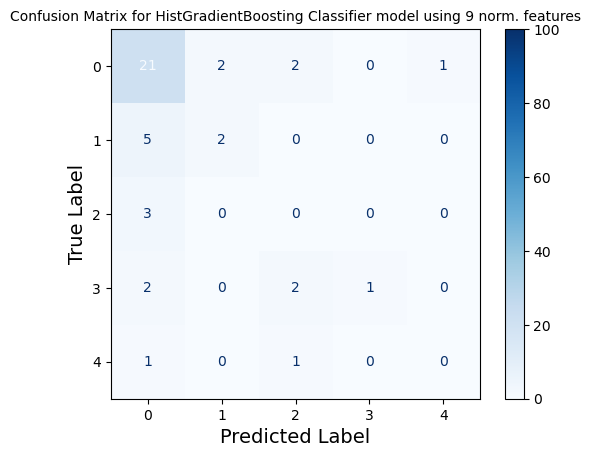

In [338]:
# Evaluate HGBC model's performance: checking prediction vs. real values: 5 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_HGBC)
# Define fixed scale (adjust manually or use max of multiple matrices)
max_value=100
# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
# Plot confusion matrix
fig, ax = plt.subplots()  # Create figure and axis
disp.plot(cmap="Blues", ax=ax)  # Add color for better visualization. Pass the axis object to ensure we modify it

# Manually set the color scale using `imshow()`
im = ax.images[0]  # Get the heatmap image
im.set_clim(0, max_value)  # Set fixed scale from 0 to max_value

# Plot confusion matrix
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix for HistGradientBoosting Classifier model using 9 norm. features", fontsize=10)
# Show the plot
plt.show()

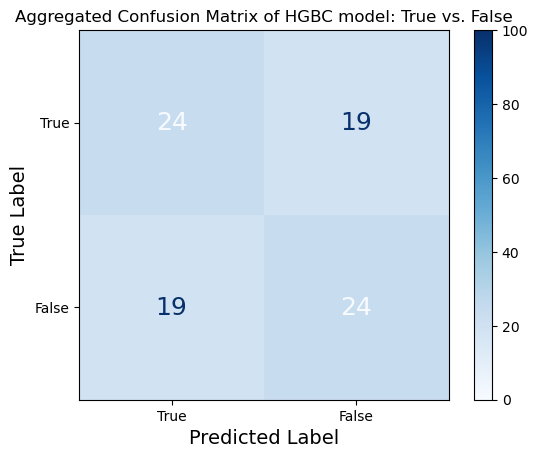

In [344]:
# Evaluate HGBC model's performance: checking prediction vs. real values: 2 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_HGBC)

# Aggregate confusion matrix into "True" and "False" categories
true_positive = np.trace(cm_train)  # Sum of diagonal elements (correct predictions)
false_positive = np.sum(cm_train) - true_positive  # Sum of all non-diagonal elements (misclassifications)

# Create a new binary confusion matrix
cm_aggregated = np.array([[true_positive, false_positive], [false_positive, true_positive]])

# Define fixed scale (adjust manually or use max of multiple matrices)
max_value = 100

# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=["True", "False"])

# Plot confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)

# Manually set the color scale
im = ax.images[0]
im.set_clim(0, max_value)

# Change fontsize of numbers inside the confusion matrix
for text in ax.texts:  # Modify all quadrant labels
    text.set_fontsize(18)  # Adjust font size as needed

# Labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Aggregated Confusion Matrix of HGBC model: True vs. False", fontsize=12)

# Show the plot
plt.show()

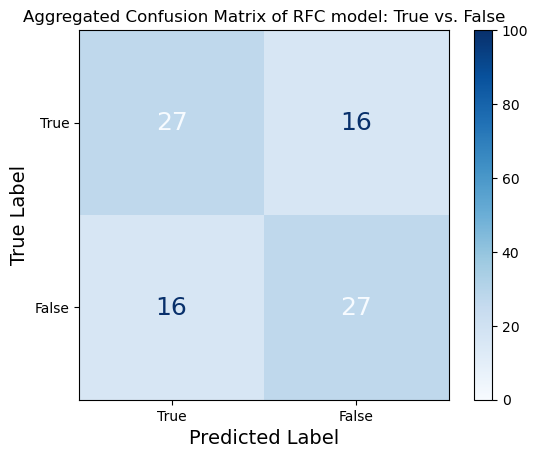

In [346]:
# Evaluate RFC model's performance: checking prediction vs. real values: 2 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_RFC)

# Aggregate confusion matrix into "True" and "False" categories
true_positive = np.trace(cm_train)  # Sum of diagonal elements (correct predictions)
false_positive = np.sum(cm_train) - true_positive  # Sum of all non-diagonal elements (misclassifications)

# Create a new binary confusion matrix
cm_aggregated = np.array([[true_positive, false_positive], [false_positive, true_positive]])

# Define fixed scale (adjust manually or use max of multiple matrices)
max_value = 100

# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=["True", "False"])

# Plot confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)

# Manually set the color scale
im = ax.images[0]
im.set_clim(0, max_value)

# Change fontsize of numbers inside the confusion matrix
for text in ax.texts:  # Modify all quadrant labels
    text.set_fontsize(18)  # Adjust font size as needed

# Labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Aggregated Confusion Matrix of RFC model: True vs. False", fontsize=12)

# Show the plot
plt.show()

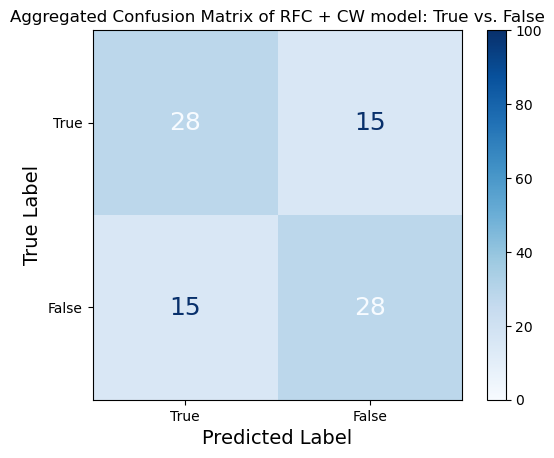

In [348]:
# Evaluate RFC + CW model's performance: checking prediction vs. real values: 2 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_RFC_CW)

# Aggregate confusion matrix into "True" and "False" categories
true_positive = np.trace(cm_train)  # Sum of diagonal elements (correct predictions)
false_positive = np.sum(cm_train) - true_positive  # Sum of all non-diagonal elements (misclassifications)

# Create a new binary confusion matrix
cm_aggregated = np.array([[true_positive, false_positive], [false_positive, true_positive]])

# Define fixed scale (adjust manually or use max of multiple matrices)
max_value = 100

# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=["True", "False"])

# Plot confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)

# Manually set the color scale
im = ax.images[0]
im.set_clim(0, max_value)

# Change fontsize of numbers inside the confusion matrix
for text in ax.texts:  # Modify all quadrant labels
    text.set_fontsize(18)  # Adjust font size as needed

# Labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Aggregated Confusion Matrix of RFC + CW model: True vs. False", fontsize=12)

# Show the plot
plt.show()

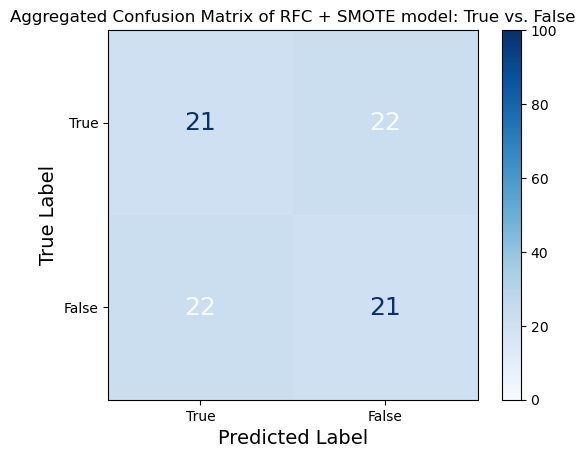

In [350]:
# Evaluate RFC + SMOTE model's performance: checking prediction vs. real values: 2 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_RFC_SMOTE)

# Aggregate confusion matrix into "True" and "False" categories
true_positive = np.trace(cm_train)  # Sum of diagonal elements (correct predictions)
false_positive = np.sum(cm_train) - true_positive  # Sum of all non-diagonal elements (misclassifications)

# Create a new binary confusion matrix
cm_aggregated = np.array([[true_positive, false_positive], [false_positive, true_positive]])

# Define fixed scale (adjust manually or use max of multiple matrices)
max_value = 100

# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=["True", "False"])

# Plot confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)

# Manually set the color scale
im = ax.images[0]
im.set_clim(0, max_value)

# Change fontsize of numbers inside the confusion matrix
for text in ax.texts:  # Modify all quadrant labels
    text.set_fontsize(18)  # Adjust font size as needed

# Labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Aggregated Confusion Matrix of RFC + SMOTE model: True vs. False", fontsize=12)

# Show the plot
plt.show()

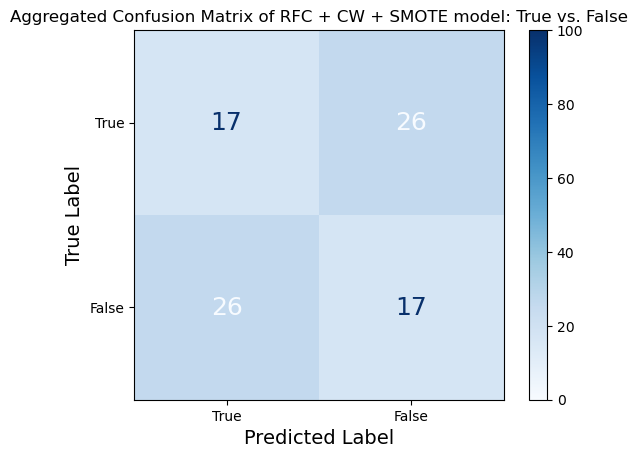

In [352]:
# Evaluate RFC + CW + SMOTE model's performance: checking prediction vs. real values: 2 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_RFC_CW_SMOTE)

# Aggregate confusion matrix into "True" and "False" categories
true_positive = np.trace(cm_train)  # Sum of diagonal elements (correct predictions)
false_positive = np.sum(cm_train) - true_positive  # Sum of all non-diagonal elements (misclassifications)

# Create a new binary confusion matrix
cm_aggregated = np.array([[true_positive, false_positive], [false_positive, true_positive]])

# Define fixed scale (adjust manually or use max of multiple matrices)
max_value = 100

# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=["True", "False"])

# Plot confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)

# Manually set the color scale
im = ax.images[0]
im.set_clim(0, max_value)

# Change fontsize of numbers inside the confusion matrix
for text in ax.texts:  # Modify all quadrant labels
    text.set_fontsize(18)  # Adjust font size as needed

# Labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Aggregated Confusion Matrix of RFC + CW + SMOTE model: True vs. False", fontsize=12)

# Show the plot
plt.show()

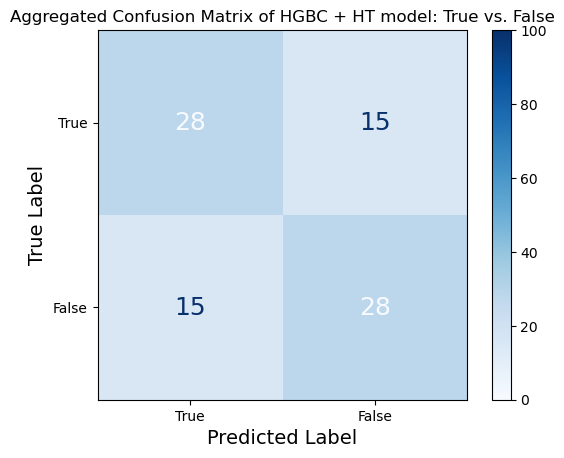

In [356]:
# Evaluate HGBC + Hyperparametertuning model's performance: checking prediction vs. real values: 2 categories confusion matrix

# Compute confusion matrix
cm_train = confusion_matrix(y_test, pred_HGBC_CV_best)

# Aggregate confusion matrix into "True" and "False" categories
true_positive = np.trace(cm_train)  # Sum of diagonal elements (correct predictions)
false_positive = np.sum(cm_train) - true_positive  # Sum of all non-diagonal elements (misclassifications)

# Create a new binary confusion matrix
cm_aggregated = np.array([[true_positive, false_positive], [false_positive, true_positive]])

# Define fixed scale (adjust manually or use max of multiple matrices)
max_value = 100

# Create ConfusionMatrixDisplay with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aggregated, display_labels=["True", "False"])

# Plot confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap="Blues", ax=ax)

# Manually set the color scale
im = ax.images[0]
im.set_clim(0, max_value)

# Change fontsize of numbers inside the confusion matrix
for text in ax.texts:  # Modify all quadrant labels
    text.set_fontsize(18)  # Adjust font size as needed

# Labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Aggregated Confusion Matrix of HGBC + HT model: True vs. False", fontsize=12)

# Show the plot
plt.show()